## **Decision Trees**

Decision Trees are capable of finding  **complex non-linear relationships** in the data. 

They can perform both **classification** and **regression** tasks.


## **Decision Trees for Regression**


In the first half of this notebook, we will demonstrate decision trees for regression task with Califiornia housing dataset and `DecisionTreeRegressor` class in `sklearn`. 


### **Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()

from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.tree import export_text

import warnings  
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(36)

Let's use `ShuffleSplit` as cv with 10 splits and 20 % examples set aside as test examples.

In [3]:
cv = ShuffleSplit(n_splits=10,test_size=0.2,random_state=42) 

### **Loading the dataset**

In [4]:
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)

### **Data Splitting**

In [5]:
com_train_features, test_features, com_train_labels, test_labels = train_test_split(features, labels, random_state=42)


train_features, dev_features, train_labels, dev_labels = train_test_split(com_train_features, com_train_labels, random_state=42)

### **Model Setup**

In [6]:
dt_reg_pipeline = Pipeline([('scaler', StandardScaler()),
                            ('dt_reg', DecisionTreeRegressor(max_depth=3, random_state=42))])

dt_reg_cv_results = cross_validate(dt_reg_pipeline,
                                   com_train_features,
                                   com_train_labels,
                                   cv=cv,
                                   scoring='neg_mean_absolute_error',
                                   return_train_score=True,
                                   return_estimator=True)

In [7]:
dt_reg_train_error = -1 * dt_reg_cv_results['train_score']
dt_reg_test_error = -1 * dt_reg_cv_results['test_score']

print(f'Mean absolute error of linear regression model on the train set : \n'
      f'{dt_reg_train_error.mean():.3f}+/- {dt_reg_train_error.std():.3f}')

print()

print(f'Mean absolute error of linear regression model on the test set : \n'
      f'{dt_reg_test_error.mean():.3f}+/- {dt_reg_test_error.std():.3f}')

Mean absolute error of linear regression model on the train set : 
0.590+/- 0.005

Mean absolute error of linear regression model on the test set : 
0.593+/- 0.007


### **Visualizing the tree**
One of the advantages of using a decision tree classifier is that the output is intuitive to understand and can be easily visualized.

This can be done in two ways:
* As a tree digram

* As a text based diagram


#### 1. **As a tree diagram**

We need to call `fit` function on `pipeline` object before printing the tree. 

In [8]:
dt_reg_pipeline.fit(train_features, train_labels)

Pipeline(steps=[('scaler', StandardScaler()),
                ('dt_reg',
                 DecisionTreeRegressor(max_depth=3, random_state=42))])

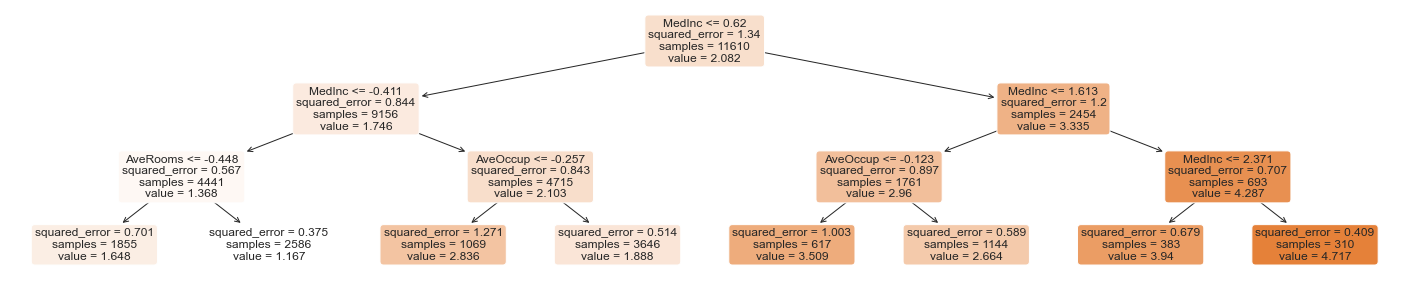

In [9]:
plt.figure(figsize=(25,5))

a = tree.plot_tree(dt_reg_pipeline[-1],
                   feature_names=features.columns,
                   rounded=True,
                   filled=True,
                   fontsize=12)

plt.show()

#### 2. **As a text-based diagram**

In [10]:
# export the decision rules
tree_rules = export_text(dt_reg_pipeline[-1])

print(tree_rules)

|--- feature_0 <= 0.62
|   |--- feature_0 <= -0.41
|   |   |--- feature_2 <= -0.45
|   |   |   |--- value: [1.65]
|   |   |--- feature_2 >  -0.45
|   |   |   |--- value: [1.17]
|   |--- feature_0 >  -0.41
|   |   |--- feature_5 <= -0.26
|   |   |   |--- value: [2.84]
|   |   |--- feature_5 >  -0.26
|   |   |   |--- value: [1.89]
|--- feature_0 >  0.62
|   |--- feature_0 <= 1.61
|   |   |--- feature_5 <= -0.12
|   |   |   |--- value: [3.51]
|   |   |--- feature_5 >  -0.12
|   |   |   |--- value: [2.66]
|   |--- feature_0 >  1.61
|   |   |--- feature_0 <= 2.37
|   |   |   |--- value: [3.94]
|   |   |--- feature_0 >  2.37
|   |   |   |--- value: [4.72]



### **Using the tree for prediction**

In [11]:
test_labels_pred = dt_reg_pipeline.predict(test_features)

### **Evaluating the tree** 

In [12]:
mae = mean_absolute_error(test_labels, test_labels_pred) 
mse = mean_squared_error(test_labels, test_labels_pred) 
r2 = r2_score(test_labels, test_labels_pred) 

print('MAE : ',mae)
print('MSE : ',mse)
print('R2 score : ',r2) 

MAE :  0.6005762942842664
MSE :  0.6417557936098145
R2 score :  0.5150037690483743


### **HPT using GridSearchCV**

Let us now try to improve the model by tuning the hyperparameters.

In [13]:
param_grid = {'dt_reg__max_depth': range(1, 20),
              'dt_reg__min_samples_split': range(2, 8)}

dt_grid_search = GridSearchCV(dt_reg_pipeline,
                              param_grid=param_grid,
                              n_jobs=2,
                              cv=cv,
                              scoring='neg_mean_absolute_error',
                              return_train_score=True)

In [14]:
dt_grid_search.fit(com_train_features, com_train_labels)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('dt_reg',
                                        DecisionTreeRegressor(max_depth=3,
                                                              random_state=42))]),
             n_jobs=2,
             param_grid={'dt_reg__max_depth': range(1, 20),
                         'dt_reg__min_samples_split': range(2, 8)},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [15]:
dt_grid_search.best_params_

{'dt_reg__max_depth': 11, 'dt_reg__min_samples_split': 5}

In [16]:
print('Mean cross validated score of the best estimator : ', -
      1*dt_grid_search.best_score_)


Mean cross validated score of the best estimator :  0.4283313044233501


In [17]:
mean_train_error = -1 * \
    dt_grid_search.cv_results_['mean_train_score'][dt_grid_search.best_index_]

mean_test_error = -1 * \
    dt_grid_search.cv_results_['mean_test_score'][dt_grid_search.best_index_]

std_train_error = -1 * \
    dt_grid_search.cv_results_['std_train_score'][dt_grid_search.best_index_]

std_test_error = -1 * \
    dt_grid_search.cv_results_['std_test_score'][dt_grid_search.best_index_]


print(f'Best Mean absolute error of decision tree regression model on the train set: \n'f'{mean_train_error:.3f} +/- {std_train_error:.3f}')

print()

print(f'Best Mean absolute error of decision tree regression model on the test set: \n'f'{mean_test_error:.3f} +/- {std_test_error:.3f}')


Best Mean absolute error of decision tree regression model on the train set: 
0.278 +/- -0.006

Best Mean absolute error of decision tree regression model on the test set: 
0.428 +/- -0.012


Let's retrain the model with the best hyperparameter value.

In [18]:
dt_reg_pipeline.set_params(dt_reg__max_depth=11, dt_reg__min_samples_split=5).fit(com_train_features, com_train_labels)

Pipeline(steps=[('scaler', StandardScaler()),
                ('dt_reg',
                 DecisionTreeRegressor(max_depth=11, min_samples_split=5,
                                       random_state=42))])

Evaluating after HPT.

In [19]:
test_labels_pred = dt_reg_pipeline.predict(test_features)

In [20]:
mae = mean_absolute_error(test_labels, test_labels_pred) 
mse = mean_squared_error(test_labels, test_labels_pred) 
r2 = r2_score(test_labels, test_labels_pred)

print('MAE : ',mae)
print('MSE : ',mse)
print('R2 score : ',r2) 

MAE :  0.4248952183820017
MSE :  0.4154957726373763
R2 score :  0.6859960039130073


## **Decision Trees using Pipelines**

For this section of the notebook, we will use **Abalone data**.

### **Loading the dataset**

* Abalone is a type of consumable snail whose price varies as per its age. 

* The aim is to predict the age of abalone from physical measurements.

* The age of abalone is traditionally determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope-a boring and time-consuming task. 

* Other measurements, which are easier to obtain, are used to predict the age.

In [21]:
column_names = ['Sex','Length','Diameter','Height','Whole weight','Shucked weight','Viscera weight','Shell weight','Rings'] 

abalone_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data', header=None,names=column_names)

In [22]:
abalone_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [23]:
abalone_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Length,4177.0,0.523992,0.120093,0.0750,0.4500,0.5450,0.615,0.8150
Diameter,4177.0,0.407881,0.099240,0.0550,0.3500,0.4250,0.480,0.6500
Height,4177.0,0.139516,0.041827,0.0000,0.1150,0.1400,0.165,1.1300
Whole weight,4177.0,0.828742,0.490389,0.0020,0.4415,0.7995,1.153,2.8255
Shucked weight,4177.0,0.359367,0.221963,0.0010,0.1860,0.3360,0.502,1.4880
Viscera weight,4177.0,0.180594,0.109614,0.0005,0.0935,0.1710,0.253,0.7600
Shell weight,4177.0,0.238831,0.139203,0.0015,0.1300,0.2340,0.329,1.0050
Rings,4177.0,9.933684,3.224169,1.0000,8.0000,9.0000,11.000,29.0000


Let's now see the type and name of the features :

 * **Sex**: The is the gender of the abalone and has categorical value (M, F or I) 

 * **Length**: The longest measurement of the abalone shell in mm. Continuous numeric value.

 * **Diameter**: The measurement of the abalone shell perpendicular to lenght in mm. Continuous numeric value.

 * **Height**: Height of the shell in mm. Continuous numeric value. Whole Weight: Weight of the abalone in grams. Continous numeric value.

 * **Shucked Weight**: Weight of just the meat in abalone in grams. Continuous numeric value.

 * **Viscera Weight**: Weight of the abalone after bleeding in grams. Continuous numeric value.

 * **Shell Weight**: Weight of the abalone after being dried in grams. Continuous numeric value.

 * **Rings**: This is the target, that is the feature that we will train the model to predict. As mentioned earlier, we are interested in the age of the abalone and it has been established that number of rings + 1.5 gives the age. Discrete numeric value.

### **Visualization of Abalone Dataset**

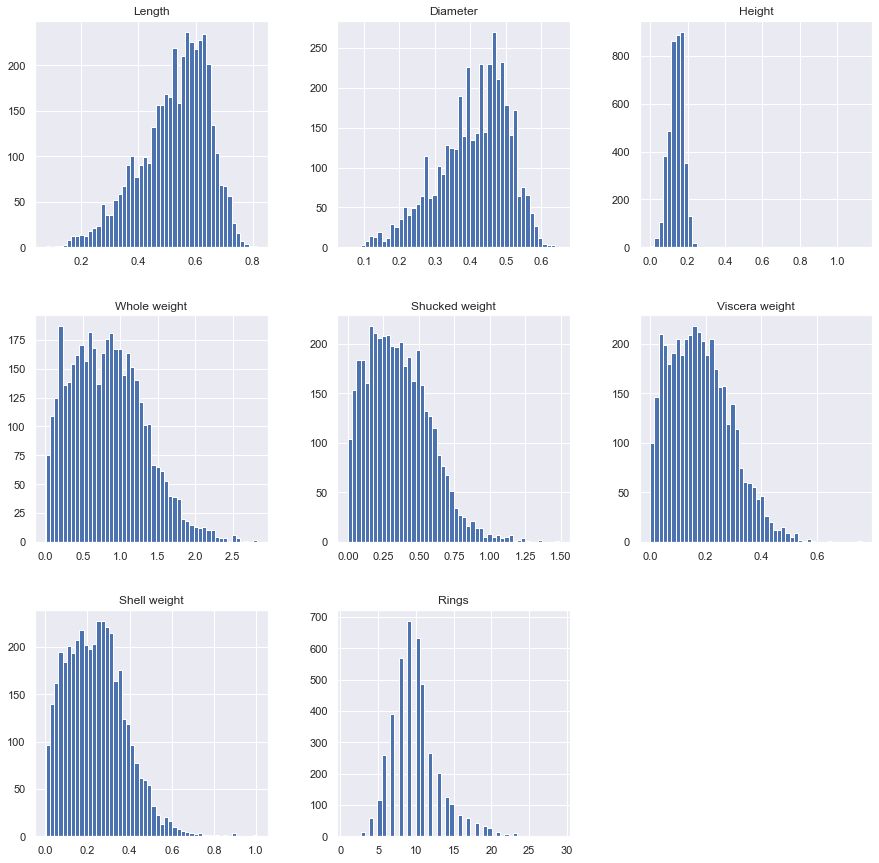

In [24]:
abalone_data.hist(bins=50, figsize=(15,15))
plt.show()

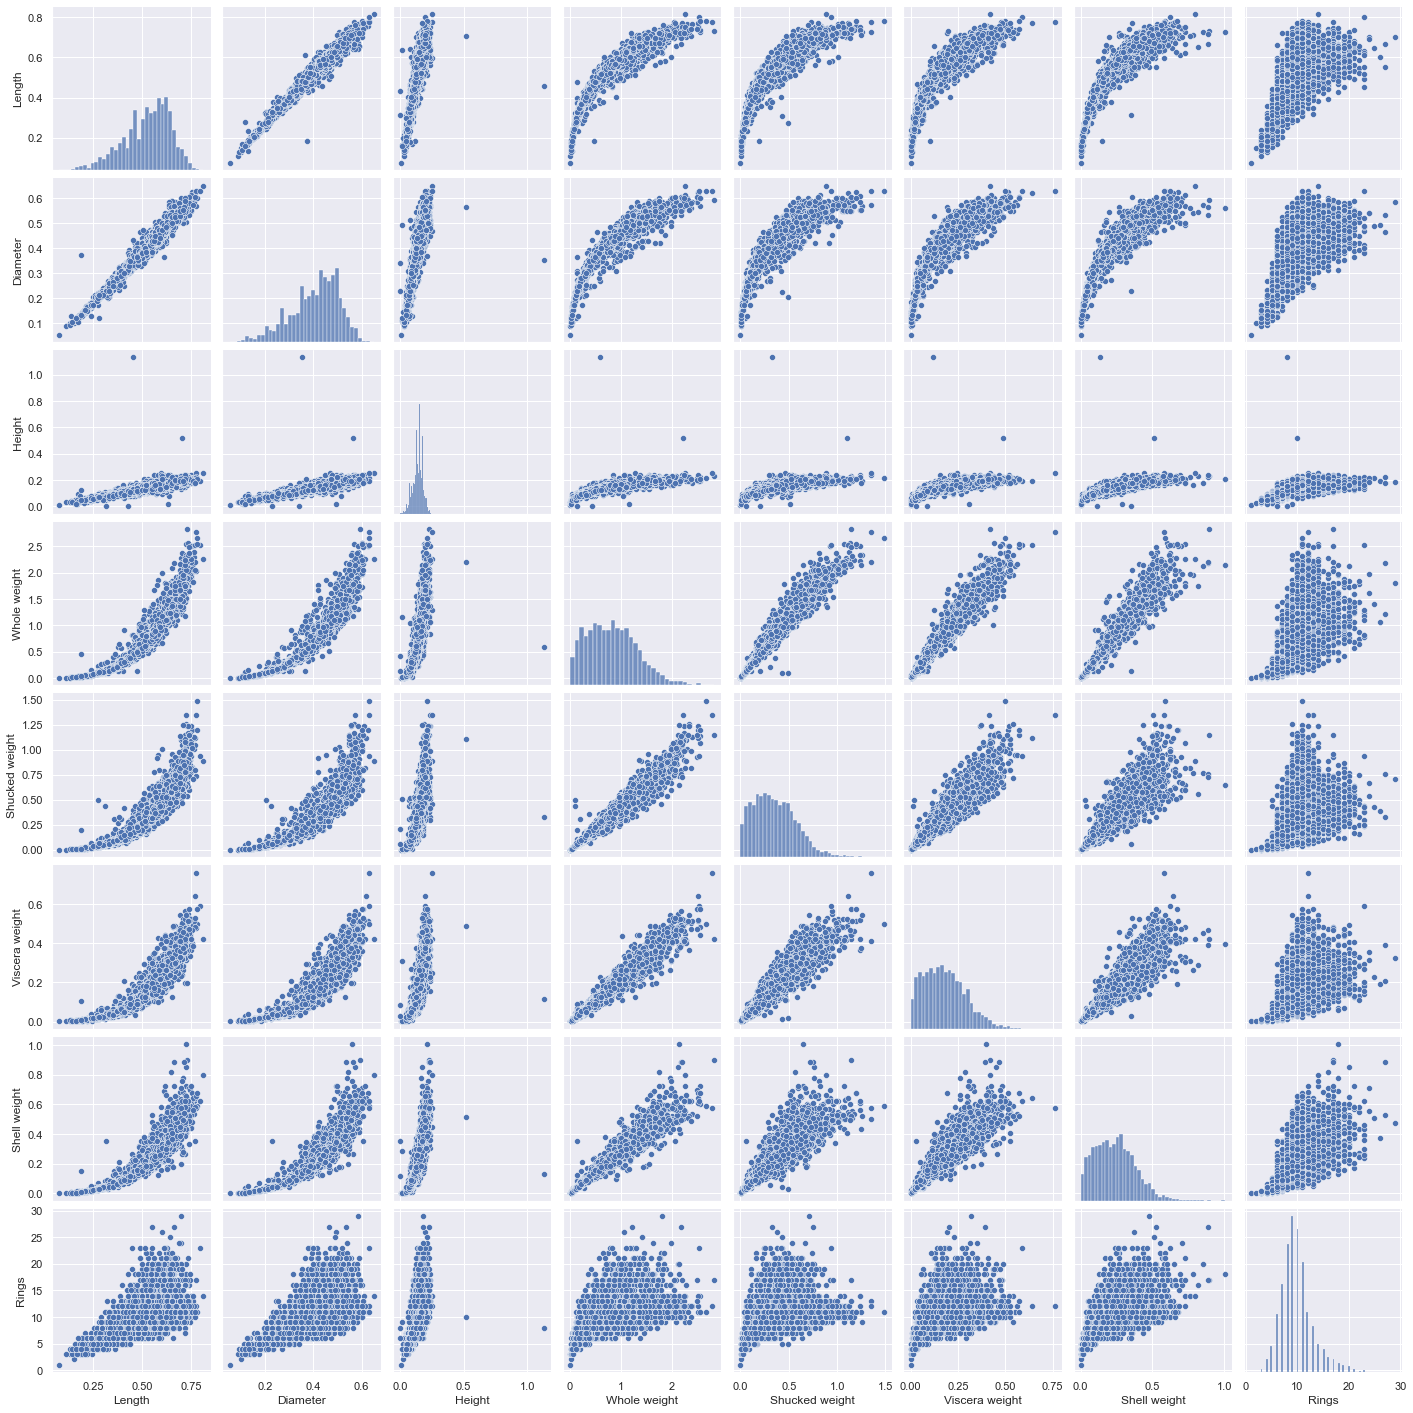

In [25]:
sns.pairplot(abalone_data, diag_kind='hist')
plt.show()

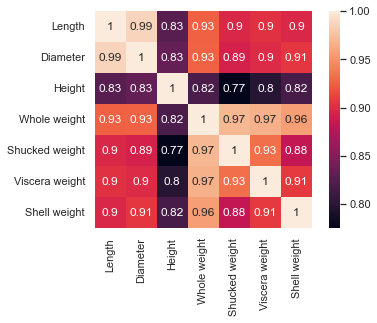

In [26]:
sns.heatmap(abalone_data.iloc[:, :-1].corr(), annot=True, square=True)
plt.show()

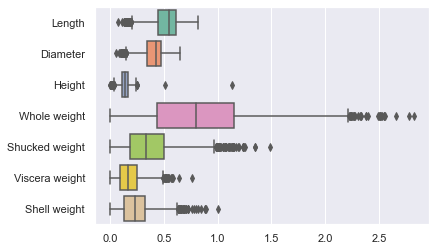

In [27]:
sns.boxplot(data=abalone_data.iloc[:, :-1], orient='h', palette='Set2')
plt.show()

We find different features to be having different ranges through this box-plot, which indicates that scaling the features may be useful.

### **Preprocessing**

From the information above, all features are continuous variables except for the Sex feature.

#### **Handling Missing values**

In [28]:
abalone_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Length,4177.0,0.523992,0.120093,0.0750,0.4500,0.5450,0.615,0.8150
Diameter,4177.0,0.407881,0.099240,0.0550,0.3500,0.4250,0.480,0.6500
Height,4177.0,0.139516,0.041827,0.0000,0.1150,0.1400,0.165,1.1300
Whole weight,4177.0,0.828742,0.490389,0.0020,0.4415,0.7995,1.153,2.8255
Shucked weight,4177.0,0.359367,0.221963,0.0010,0.1860,0.3360,0.502,1.4880
Viscera weight,4177.0,0.180594,0.109614,0.0005,0.0935,0.1710,0.253,0.7600
Shell weight,4177.0,0.238831,0.139203,0.0015,0.1300,0.2340,0.329,1.0050
Rings,4177.0,9.933684,3.224169,1.0000,8.0000,9.0000,11.000,29.0000


The count row shows that there are no missing values.

However, in the `Height feature`, the minimum value is zero. This possibility calls for a missing value in the data and we will process tha missing value.

We first check how many missing values are in the `Height feature` and which class is it in.

In [29]:
(abalone_data['Height']==0).sum()

2

In [30]:
abalone_data[abalone_data['Height']==0]

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
1257,I,0.430,0.34,0.0,0.428,0.2065,0.0860,0.1150,8
3996,I,0.315,0.23,0.0,0.134,0.0575,0.0285,0.3505,6


The number of missing values is 2 and is in the infant sex. 

Then we change the value 0 to null. We will fill in the missing value with the average Height feature for the infant gender.

In [31]:
mean = pd.pivot_table(abalone_data, index=['Sex'], aggfunc={'Height': np.mean})
mean

,Height
Sex,
F,0.158011
I,0.107996
M,0.151381


So we will fill in the missing value with 0.107996. (will perform the next step a little later)

#### **Target Column**


Next, take a look at the target in this case in the Rings column

In [32]:
abalone_data['Rings'].unique()

array([15,  7,  9, 10,  8, 20, 16, 19, 14, 11, 12, 18, 13,  5,  4,  6, 21,
       17, 22,  1,  3, 26, 23, 29,  2, 27, 25, 24], dtype=int64)

In [33]:
abalone_data['Rings'].value_counts().sort_index()

1       1
2       1
3      15
4      57
5     115
6     259
7     391
8     568
9     689
10    634
11    487
12    267
13    203
14    126
15    103
16     67
17     58
18     42
19     32
20     26
21     14
22      6
23      9
24      2
25      1
26      1
27      2
29      1
Name: Rings, dtype: int64

We can see that the target is 1 to 29 (but there is no 28), so the classification we are goinng to do is a multi-class classification.

### **Storing data in the form of X & y**

In [34]:
X = abalone_data.iloc[:,:-1] 
y = abalone_data.iloc[:,-1]

In [35]:
X[:5] 

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055


In [36]:
y[:5]

0    15
1     7
2     9
3    10
4     7
Name: Rings, dtype: int64

### **Splitting data into train and test sets.**

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

### **Pipelining**

We will use pipelines to perform preprocessing of the data, which will include: handling missing (or 0) values, scaling the features and handling the categorical feature (viz., sex in this case) 

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

Identifying numeric and categorical features (to be able to preprocess them differently.)

In [39]:
numeric_features = ['Length','Diameter','Height','Whole weight','Shucked weight', 'Viscera weight', 'Shell weight'] 

categorical_features = ['Sex'] 

In [40]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=0, strategy='constant',fill_value=0.107996)),
    ('scaler',StandardScaler())
    ])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [41]:
preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features),
                  ('cat', categorical_transformer, categorical_features)]
)

In [42]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.

clf = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('classifier', DecisionTreeClassifier(max_depth=3, random_state=42))]
)

In [43]:
clf.fit(X_train, y_train)
print('Model score : {:.3f}'.format(clf.score(X_test,y_test)))

Model score : 0.245


### **Evaluation**

In [44]:
y_pred = clf.predict(X_test)

Let us compare the actual and predicted values of y.

In [45]:
# comparision = np.concatenate(
#     (y_pred.reshape(len(y_pred), 1), y_test.values.reshape(len(y_test), 1)), 1)

# for each in comparision:
#     print(each)

**Confusion Matrix by ConfusionMatrixDisplay**

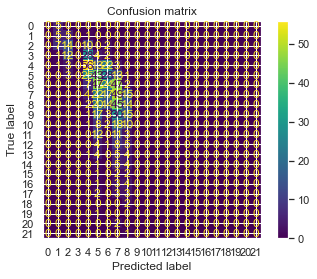

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title('Confusion matrix')
plt.show()


**Confusion Matrix by heatmap**

<AxesSubplot:>

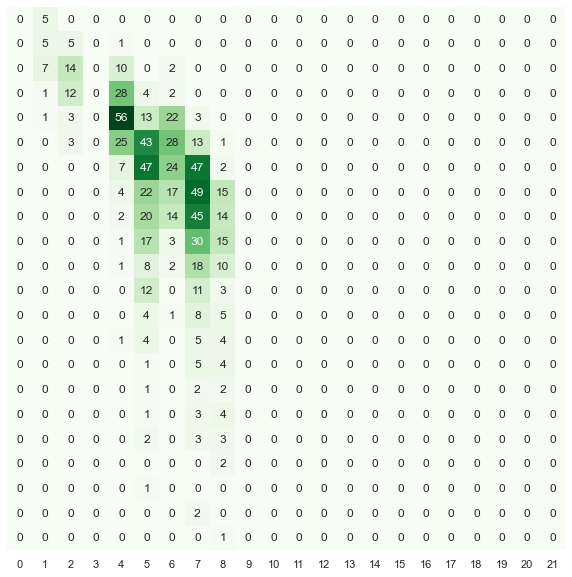

In [47]:
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_test ,y_pred) ,annot=True , yticklabels=False ,cbar=False ,cmap='Greens')

**Classification Report**

In [48]:
from sklearn.metrics import classification_report 
print(classification_report(y_test ,y_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.26      0.45      0.33        11
           5       0.38      0.42      0.40        33
           6       0.00      0.00      0.00        47
           7       0.41      0.57      0.48        98
           8       0.21      0.38      0.27       113
           9       0.21      0.19      0.20       127
          10       0.20      0.46      0.28       107
          11       0.16      0.15      0.16        95
          12       0.00      0.00      0.00        66
          13       0.00      0.00      0.00        39
          14       0.00      0.00      0.00        26
          15       0.00      0.00      0.00        18
          16       0.00      0.00      0.00        14
          17       0.00      0.00      0.00        10
          18       0.00      0.00      0.00         5
          19       0.00      0.00      0.00         8
          20       0.00    

**Cross-Val Score**

In [49]:
from sklearn.model_selection import cross_val_score
acc = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10)

print('Accuracy of each fold : \n', list(acc*100))
print()
print('Accuracy : ',acc.mean()*100)

Accuracy of each fold : 
 [27.46268656716418, 22.45508982035928, 23.952095808383234, 24.550898203592812, 24.251497005988025, 23.952095808383234, 25.449101796407188, 30.83832335329341, 26.34730538922156, 26.047904191616766]

Accuracy :  25.530699794440963


### **Visualizing the decision tree** 

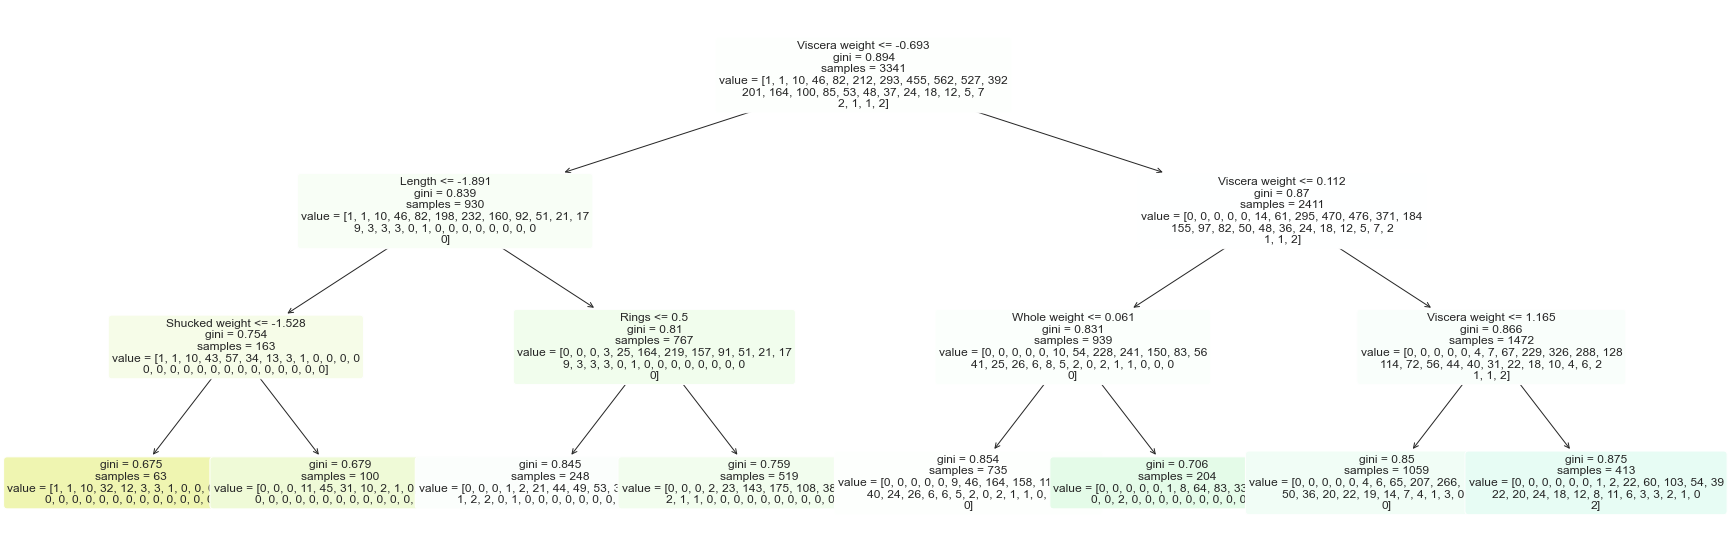

In [50]:
plt.figure(figsize=(30,10))
a = tree.plot_tree(clf['classifier'],
                   feature_names=column_names,
                   rounded=True,
                   filled=True,
                   fontsize=12)

plt.show()

### **Finding the best parameters using GridSearchCV** 

In [51]:
X_train_new = preprocessor.fit_transform(X_train)

In [52]:
tuned_parameters = [{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                     'min_samples_split':[2, 4, 6, 8, 10]}]

scores = ['recall']

In [53]:
for score in scores:

    clf_cv = GridSearchCV(DecisionTreeClassifier(),
                        tuned_parameters,
                        scoring=f'{score}_macro')

    clf_cv.fit(X_train_new, y_train)

    print('Best parameters :' ,clf_cv.best_params_)
    print()
    print('Grid Score is as follows : \n')
    means = clf_cv.cv_results_['mean_test_score']
    stds = clf_cv.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf_cv.cv_results_['params']):
        print(f'{mean:0.3f} (+/-) {std*2:0.03f} for {params}')


Best parameters : {'max_depth': 5, 'min_samples_split': 2}

Grid Score is as follows : 

0.073 (+/-) 0.009 for {'max_depth': 1, 'min_samples_split': 2}
0.073 (+/-) 0.009 for {'max_depth': 1, 'min_samples_split': 4}
0.073 (+/-) 0.009 for {'max_depth': 1, 'min_samples_split': 6}
0.073 (+/-) 0.009 for {'max_depth': 1, 'min_samples_split': 8}
0.073 (+/-) 0.009 for {'max_depth': 1, 'min_samples_split': 10}
0.107 (+/-) 0.011 for {'max_depth': 2, 'min_samples_split': 2}
0.107 (+/-) 0.011 for {'max_depth': 2, 'min_samples_split': 4}
0.107 (+/-) 0.011 for {'max_depth': 2, 'min_samples_split': 6}
0.107 (+/-) 0.011 for {'max_depth': 2, 'min_samples_split': 8}
0.107 (+/-) 0.011 for {'max_depth': 2, 'min_samples_split': 10}
0.131 (+/-) 0.012 for {'max_depth': 3, 'min_samples_split': 2}
0.131 (+/-) 0.012 for {'max_depth': 3, 'min_samples_split': 4}
0.131 (+/-) 0.012 for {'max_depth': 3, 'min_samples_split': 6}
0.131 (+/-) 0.012 for {'max_depth': 3, 'min_samples_split': 8}
0.131 (+/-) 0.012 for {'max

Let us now create a new pipeline using the best features identified above.

In [54]:
clf2 = Pipeline(steps=[('preprocessor',preprocessor),
                       ('classifier',DecisionTreeClassifier(max_depth=5,min_samples_split = 2, random_state=42))] )

In [55]:
clf2.fit(X_train, y_train) 
print('Model score  : {:.3f}'.format(clf2.score(X_test,y_test)))

Model score  : 0.272


## **Decision Trees for Classification**

In this half of the notebook, we will demonstrate decision trees for classification task with **Iris dataset** and `DecisionTreeClassifier` class in `sklearn`. 

Let's load Iris dataset with `load_iris`API

In [56]:
from sklearn.datasets import load_iris
features, labels = load_iris(return_X_y=True, as_frame=True)


Let's split the data into train and test.

In [57]:
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.2, random_state=42)

Define the decision tree classifier as part of `pipeline`.

In [58]:
from sklearn.preprocessing import MinMaxScaler

dt_pipeline = Pipeline([('scaler', MinMaxScaler()),
                        ('dt_classifier', DecisionTreeClassifier(max_depth=3,random_state=42))])

Training the classifier.

In [59]:
dt_pipeline.fit(train_features, train_labels)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('dt_classifier',
                 DecisionTreeClassifier(max_depth=3, random_state=42))])

Now that the classifier is trained, let's evaluate it on the test set with : 
 * Confusion matrix 

 * Classification report 

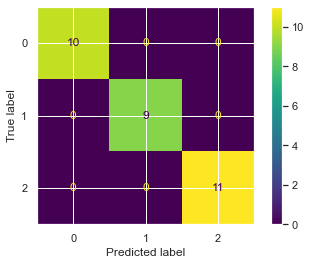

In [60]:
ConfusionMatrixDisplay.from_estimator(dt_pipeline, test_features, test_labels)
plt.show()

In [61]:
print(classification_report(test_labels, dt_pipeline.predict(test_features)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



As a next step let's visualize the trained decision tree model.

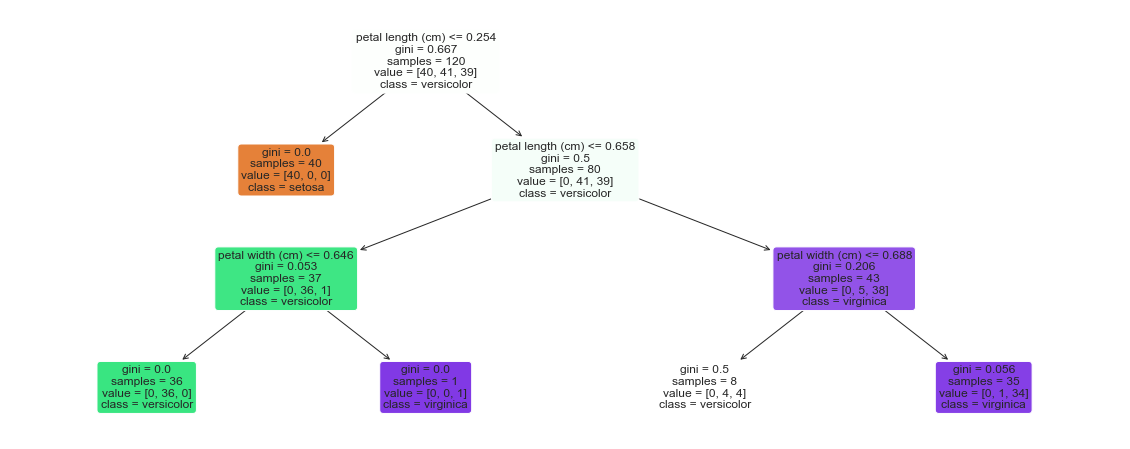

In [62]:
plt.figure(figsize=(20, 8))

a = tree.plot_tree(dt_pipeline[-1],
                   #use the feature names stored
                   feature_names=features.columns,
                   #use the class names stored
                   class_names=load_iris().target_names,
                   rounded=True,
                   filled=True,
                   fontsize=12)

plt.show()

Let's convert this tree representation into if-else rule set.

In [63]:
#export the decision rules
tree_rules = export_text(dt_pipeline[-1], feature_names=list(features.columns))

print(tree_rules)

|--- petal length (cm) <= 0.25
|   |--- class: 0
|--- petal length (cm) >  0.25
|   |--- petal length (cm) <= 0.66
|   |   |--- petal width (cm) <= 0.65
|   |   |   |--- class: 1
|   |   |--- petal width (cm) >  0.65
|   |   |   |--- class: 2
|   |--- petal length (cm) >  0.66
|   |   |--- petal width (cm) <= 0.69
|   |   |   |--- class: 1
|   |   |--- petal width (cm) >  0.69
|   |   |   |--- class: 2



Let's get the feature importance from the trained decision tree model.

In [64]:
importance = pd.DataFrame({'features': features.columns,
                           'importance': np.round(dt_pipeline[-1].feature_importances_, 4)})

importance.sort_values('importance', ascending=False, inplace=True)
print(importance)

            features  importance
2  petal length (cm)      0.9346
3   petal width (cm)      0.0654
0  sepal length (cm)      0.0000
1   sepal width (cm)      0.0000


Now, perform HPT using GridSearchCV : 

There are two configurable parameters in the tree classifier :

* `max_depth`

* `min_samples_split`

In [65]:
param_grid = [{'dt_classifier__max_depth': [1, 2, 3, 4, 5],
            'dt_classifier__min_samples_split': [2, 4, 6, 8, 10]}]


In [66]:
gs_clf = GridSearchCV(dt_pipeline, param_grid, scoring='f1_macro')
gs_clf.fit(train_features, train_labels)

print('Best parameters : ', gs_clf.best_params_)
print()

print('Grid scores are as follows : \n')
means = gs_clf.cv_results_['mean_test_score']
stds = gs_clf.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, gs_clf.cv_results_['params']):
  print(f'{mean:0.3f} (+/-) {std*2:0.03f} for {params}\n')

Best parameters :  {'dt_classifier__max_depth': 4, 'dt_classifier__min_samples_split': 2}

Grid scores are as follows : 

0.559 (+/-) 0.014 for {'dt_classifier__max_depth': 1, 'dt_classifier__min_samples_split': 2}

0.559 (+/-) 0.014 for {'dt_classifier__max_depth': 1, 'dt_classifier__min_samples_split': 4}

0.559 (+/-) 0.014 for {'dt_classifier__max_depth': 1, 'dt_classifier__min_samples_split': 6}

0.559 (+/-) 0.014 for {'dt_classifier__max_depth': 1, 'dt_classifier__min_samples_split': 8}

0.559 (+/-) 0.014 for {'dt_classifier__max_depth': 1, 'dt_classifier__min_samples_split': 10}

0.916 (+/-) 0.091 for {'dt_classifier__max_depth': 2, 'dt_classifier__min_samples_split': 2}

0.916 (+/-) 0.091 for {'dt_classifier__max_depth': 2, 'dt_classifier__min_samples_split': 4}

0.916 (+/-) 0.091 for {'dt_classifier__max_depth': 2, 'dt_classifier__min_samples_split': 6}

0.916 (+/-) 0.091 for {'dt_classifier__max_depth': 2, 'dt_classifier__min_samples_split': 8}

0.916 (+/-) 0.091 for {'dt_clas

Confusion matrix for the best estimator obtained through the `GridSearchCV`.

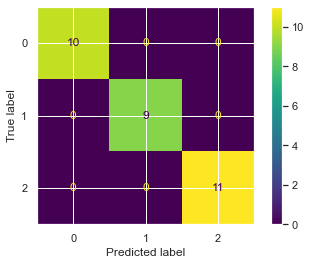

In [67]:
ConfusionMatrixDisplay.from_estimator(
    gs_clf.best_estimator_, test_features, test_labels)

plt.show()